#  (概述) Fully-Connected Neural Nets

    使用 更模块化 的设计构建网络(每一层有forward + backward function)，
    以便 隔离 实现不同的层类型，
    然后 将它们 集成到具有不同体系结构的模型中。
    
    每一层有 a forward and a backward function

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

# 概述：Batch Normalization

    使深层网络更容易训练的方法 
    -->>> 使用更复杂的优化程序：如SGD +momentum动量、RMSProp或Adam
    -->>> 改变网络的架构，使其更容易训练
    -->>> batch normalization

批量标准化/批量归一化/ batch normalization layer：

    通过 减少内部协变位移（Reducing Internal Covariate Shift）来加速深度网络训练

    在训练时 使用 minibatch数据 估计每个特征的均值和标准偏差

    这些 估计的均值和标准偏差 用来 中心化和标准化 minibatch特征

    在训练时 这些 估计的均值和标准偏差的 running average 保持着
    在测试时 这些  running average 用于 中心化和标准化 特性

    batch normalization layer包括 
       learnable shift（可学习的转移）
       每个特性维度的刻度参数（scale parameters）
       
    BN做的事情就是
        在每一层的开始，加上这个操作，但是有的数据可能会因此丢失了一些信息，
        所以再加上beta和gama来恢复原始数据，这里beta和gama是可学习的。


# 各代码库 说明

- data_utils.py --> 数据导入及预处理 模块
- 
- layers.py --> 普通层 模块 ： 向前+向后运算 + loss
- layer_utils.py --> 层模式 模块 : 仿射层 + ReLU非线性
- solver.py --> 训练 模块
- optim.py --> 更新规则 模块
- 
- gradient_check.py --> 梯度检查 模块


- classifiers/fc_net.py --> 分类器 模块：Two-layer network + FullyConnectedNet

# import

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from classifiers.cnn import *
from classifiers.fc_net import *
from data_utils import get_CIFAR10_data
from gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from layers import *
from fast_layers import *
from solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [1]:
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from classifiers.fc_net import *
from data_utils import get_CIFAR10_data
from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from solver import Solver

# CNN
from fast_layers import *
from classifiers.cnn import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置 size
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


# 数据预处理模块
- 导入 已预处理过的 data
- data_utils.py  --> get_CIFAR10_data()

In [20]:
data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('y_test: ', (1000,))
('y_train: ', (49000,))
('X_test: ', (1000, 3, 32, 32))
('X_train: ', (49000, 3, 32, 32))
('y_val: ', (1000,))
('X_val: ', (1000, 3, 32, 32))


# 普通层模块：Affine layer: foward  仿射层?
 `layers.py` ---> `affine_forward` function.

In [23]:
###################### Test affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])
_, cache = affine_forward(x, w, b)

# 比较 计算的结果 和 预期结果是否一致，误差应该在 1e-9 附近
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76984772881e-10


# 普通层模块：Affine layer: backward
- `layers.py` ---> `affine_backward` 

In [24]:
###################### Test affine_backward
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)
#print (dx_num.shape, dw_num.shape, db_num.shape )

_, cache = affine_forward(x, w, b)
#print (cache[0].shape, cache[1].shape, cache[2].shape)
dx, dw, db = affine_backward(dout, cache)

# 误差范围 1e-10 
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.39910036865e-11
dw error:  9.9042118654e-11
db error:  2.41228675681e-11


# 普通层模块：ReLU layer: forward
- `layers.py` ---> `relu_forward` 

In [25]:
###################### Test relu_forward

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out,_ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# # 误差范围  5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.99999979802e-08


# 普通层模块：ReLU layer: backward
- `layers.py` ---> `relu_backward` 

In [26]:
###################### Test relu_backward
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# 误差范围 3e-12 
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.27563491363e-12


# 层模式模块："Sandwich" layers  三明治层？

处理 常见的层模式：仿射层 + ReLU非线性

- `layer_utils.py` --> `affine_relu_forward` + `affine_relu_backward`


In [27]:
from layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# 误差范围 1e-10 FC_fp --> ReLU_fp ; ReLU_bp --> FC_bp
print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.7505621216e-11
dw error:  8.16201557044e-11
db error:  7.82672402146e-12


# 普通层模块： Loss layers: Softmax and SVM (不懂。。。)
作业1 已完成的内容

- `layers.py` --->

In [28]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)


#################### Test svm_loss function
# Loss should be around 9 and dx error should be 1e-9
dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


#################### Test softmax_loss function
# Loss should be 2.3 and dx error should be 1e-8
dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.9996027491
dx error:  1.40215660067e-09

Testing softmax_loss:
loss:  2.3025458445
dx error:  9.38467316199e-09


# 普通层模块：Batch normalization: Forward
- `layers.py` --> `batchnorm_forward`

- 检查 BN 的 Means + stds on training-time

In [6]:
############### 初始化1个简单的2层net
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

############### 计算 BN 前的 mean stds
print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))


############### 计算 BN 后的 mean stds
########
# Means 接近 beta = 0 
# stds 接近 gamma = 1
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))


######
#  Means 接近 beta 
# stds 接近 gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:  [ 27.18502186  34.21455511  37.68611762]
After batch normalization (gamma=1, beta=0)
  mean:  [  5.32907052e-17   7.04991621e-17   4.22578639e-17]
  std:  [ 0.99999999  1.          1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 0.99999999  1.99999999  2.99999999]


- 检查 BN 的 Means + stds on test-time

In [8]:
############### 初始化1个简单的2层net
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)


############### 计算 BN 后的 mean stds 
bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
    
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)



######
#  Means 接近 beta = 0
# stds 接近 gamma = 1
# 相对于 train-time，test-time 有更多的noise
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.02773608  0.00967768  0.14126662]
  stds:  [ 1.00879232  0.91789884  0.9155594 ]


# 普通层模块：Batch Normalization: backward
- `layers.py` --> `batchnorm_backward`.

- 检查 BN 梯度 

In [10]:
############### 初始化 2层net 和 参数
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

############### 计算 数值梯度
bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

############### 计算 BN 梯度
_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)


############### 比较 梯度
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.70292611676e-09
dgamma error:  7.42041421625e-13
dbeta error:  2.87950576558e-12


# 普通层模块：Batch Normalization: alternative backward (待续)

    sigmoid backward pass 的实现策略
        1、写出 由简单的操作 和 通过所有中间值来backprop 的 计算图
        2、在纸上做衍生品：在纸上简化梯度来推导出一个非常简单的公式

- `layers.py` --> `batchnorm_backward_alt` 


In [ ]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

# 普通层模块： Dropout forward pass
- `layers.py` -->  dropout_forward

- 检查不同的P, train 和 test 的 drop 前后的对比

In [3]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.3
Mean of input:  10.0002078785
Mean of train-time output:  10.0350727971
Mean of test-time output:  10.0002078785
Fraction of train-time output set to zero:  0.699124
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.0002078785
Mean of train-time output:  9.97691075877
Mean of test-time output:  10.0002078785
Fraction of train-time output set to zero:  0.401368
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.0002078785
Mean of train-time output:  9.99306858826
Mean of test-time output:  10.0002078785
Fraction of train-time output set to zero:  0.250496
Fraction of test-time output set to zero:  0.0



# 普通层模块： Dropout backward pass
- `layers.py` --> dropout_backward

- 检查 dropout 的梯度 (与数值梯度对比)

In [4]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44561271827e-11


# 分类器模块：Two-layer network
- `classifiers/fc_net.py`--> `TwoLayerNet` class. 

- 检查 参数、scores、损失（含/不含 正则化）、梯度（含/不含 正则化）

In [80]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)


print('###################################################')
print('Testing initialization ... ')
print ('检查 参数是否在合理的范围内...')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']

assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'


print('###################################################')
print('Testing test-time forward pass ... ')
print ('检查 scores')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'



print('###################################################')
print('Testing training loss (no regularization)')
print('检查损失（不含正则化时）')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

print('###################################################')
print('Testing training loss (with regularization)')
print('检查损失（含正则化时）')
model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'



print('###################################################')
print('检查梯度（不含 + 含  正则化时）')
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))



###################################################
Testing initialization ... 
检查 参数是否在合理的范围内...
###################################################
Testing test-time forward pass ... 
检查 scores
###################################################
Testing training loss (no regularization)
检查损失（不含正则化时）
###################################################
Testing training loss (with regularization)
检查损失（含正则化时）
###################################################
检查梯度（不含 + 含  正则化时）
Running numeric gradient check with reg =  0.0
W1 relative error: 5.00e-01
W2 relative error: 5.00e-01
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 1.00e+00
W2 relative error: 1.00e+00
b1 relative error: 1.09e-09
b2 relative error: 7.76e-10


# 分类器模块：Two-layer Nets + Dropout

In [8]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print(dropout)

    solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.274000; val_acc: 0.192000
(Epoch 1 / 25) train acc: 0.410000; val_acc: 0.263000
(Epoch 2 / 25) train acc: 0.518000; val_acc: 0.269000
(Epoch 3 / 25) train acc: 0.550000; val_acc: 0.248000
(Epoch 4 / 25) train acc: 0.684000; val_acc: 0.297000
(Epoch 5 / 25) train acc: 0.758000; val_acc: 0.292000
(Epoch 6 / 25) train acc: 0.782000; val_acc: 0.266000
(Epoch 7 / 25) train acc: 0.860000; val_acc: 0.240000
(Epoch 8 / 25) train acc: 0.864000; val_acc: 0.286000
(Epoch 9 / 25) train acc: 0.900000; val_acc: 0.278000
(Epoch 10 / 25) train acc: 0.908000; val_acc: 0.271000
(Epoch 11 / 25) train acc: 0.946000; val_acc: 0.292000
(Epoch 12 / 25) train acc: 0.954000; val_acc: 0.287000
(Epoch 13 / 25) train acc: 0.946000; val_acc: 0.281000
(Epoch 14 / 25) train acc: 0.968000; val_acc: 0.270000
(Epoch 15 / 25) train acc: 0.958000; val_acc: 0.291000
(Epoch 16 / 25) train acc: 0.934000; val_acc: 0.268000
(Epoch 17 / 25) train acc: 0.978000; v

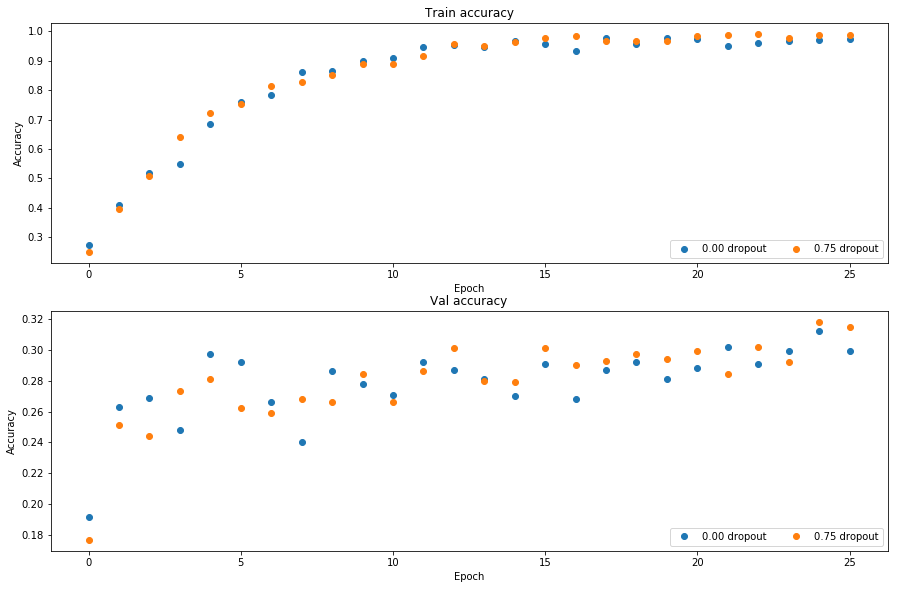

In [9]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# 分类器模块：FC network
Multilayer network / a fully-connected network

- `classifiers/fc_net.py` -->  `FullyConnectedNet` class

Implement the initialization, the forward pass, and the backward pass. 

- 检查 Initial loss and gradient 

In [7]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.30047908977
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.05211477653
W1 relative error: 1.14e-08
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


- 检查 是否 overfit a small dataset of 50 images
    overfitting一个小数据集，证明网络是有不错的学习能力的

- Use a three-layer Net to overfit 50 training examples.

 you should be able to overfit and achieve 100% training accuracy within 20 epochs

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.020000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.020000; val_acc: 0.106000
(Epoch 2 / 20) train acc: 0.020000; val_acc: 0.110000
(Epoch 3 / 20) train acc: 0.020000; val_acc: 0.110000
(Epoch 4 / 20) train acc: 0.040000; val_acc: 0.109000
(Epoch 5 / 20) train acc: 0.040000; val_acc: 0.111000
(Iteration 11 / 40) loss: 2.270022
(Epoch 6 / 20) train acc: 0.040000; val_acc: 0.111000
(Epoch 7 / 20) train acc: 0.060000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.060000; val_acc: 0.111000
(Epoch 9 / 20) train acc: 0.040000; val_acc: 0.110000
(Epoch 10 / 20) train acc: 0.040000; val_acc: 0.109000
(Iteration 21 / 40) loss: 2.309562
(Epoch 11 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 12 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 13 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 14 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 15 / 20) train acc: 0.060000; val_acc: 0.113000
(Iteration 31 / 40) loss: 

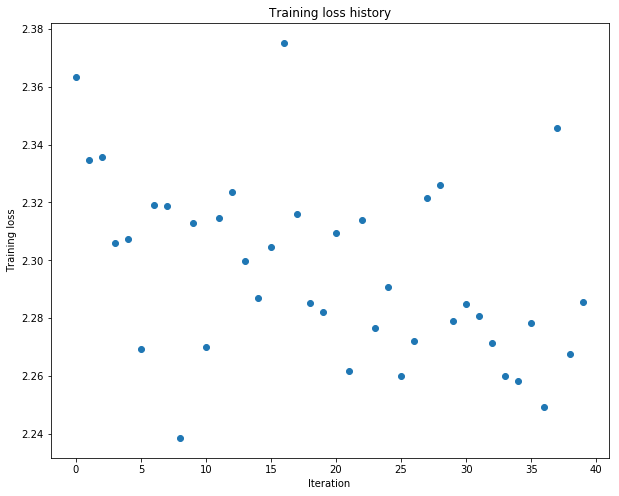

In [9]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-4
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

- Use a five-layer Net to overfit 50 training examples.

you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302273
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302221
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

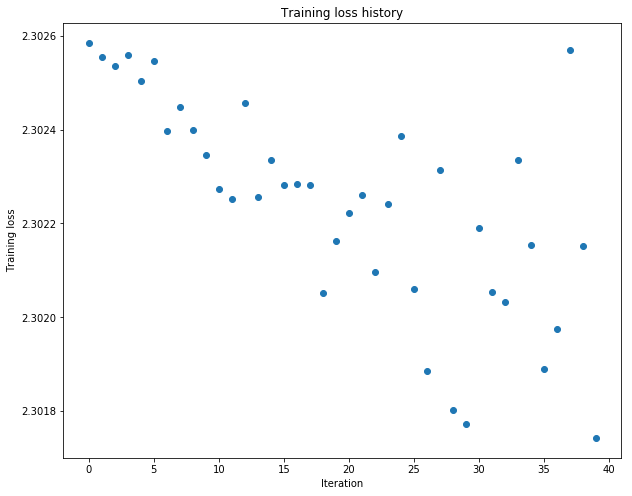

In [10]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-3
weight_scale = 1e-5
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# 分类器模块：FC Nets + Batch Normalization
- `classifiers/fc_net.py`-->   FullyConnectedNet class --> add batch normalization.


    `use_batchnorm` is `True` :
       每个 ReLU nonlinearity 前 加入 a batch normalization layer
       最后一层的outputs 不需要 normalized.

HINT: You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`. 

- 检查 FC net 是否正常使用 BN

In [11]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    if reg == 0: print()

Running check with reg =  0
Initial loss:  2.26119551013
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 3.92e-10
b1 relative error: 4.44e-08
b2 relative error: 2.22e-08
b3 relative error: 4.78e-11
beta1 relative error: 7.33e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 7.57e-09
gamma2 relative error: 1.96e-09

Running check with reg =  3.14
Initial loss:  6.99653322011
W1 relative error: 1.98e-06
W2 relative error: 2.29e-06
W3 relative error: 1.11e-08
b1 relative error: 5.55e-09
b2 relative error: 2.22e-08
b3 relative error: 2.23e-10
beta1 relative error: 6.65e-09
beta2 relative error: 3.48e-09
gamma1 relative error: 5.94e-09
gamma2 relative error: 4.14e-09


# 分类器模块：FC nets + Dropout
- `classifiers/fc_net.py`-->   FullyConnectedNet class -->add dropout. 

    `dropout` is  nonzero value :
       每个 ReLU nonlinearity 后 加入 dropout


- 检查 FC net 是否正常使用 dropout

In [6]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  0
Initial loss:  2.30047908977
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.25
Initial loss:  2.30164821578
W1 relative error: 6.96e-07
W2 relative error: 5.01e-06
W3 relative error: 2.96e-07
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.32e-10

Running check with dropout =  0.5
Initial loss:  2.29496325798
W1 relative error: 1.20e-07
W2 relative error: 5.54e-07
W3 relative error: 1.48e-06
b1 relative error: 3.30e-09
b2 relative error: 4.40e-09
b3 relative error: 1.25e-10



# 更新规则模块：  
实现一些最常用的更新规则，并将它们与 vanilla SGD比较   << -- 香草SGD??

### 更新规则1：SGD+Momentum
    梯度的更新策略
广泛使用的SGD+Momentum 比  vanilla SGD  收敛速度更快
- `optim.py` --> `sgd_momentum` 

- 检查 更新规则是否正确

In [13]:
from optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])


# errors less than 1e-8.
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


- train a six-layer network with both SGD and SGD+momentum. 
    
    You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.108000
(Iteration 11 / 200) loss: 2.291086
(Iteration 21 / 200) loss: 2.153591
(Iteration 31 / 200) loss: 2.082693
(Epoch 1 / 5) train acc: 0.277000; val_acc: 0.242000
(Iteration 41 / 200) loss: 2.004171
(Iteration 51 / 200) loss: 2.010409
(Iteration 61 / 200) loss: 2.023753
(Iteration 71 / 200) loss: 2.026621
(Epoch 2 / 5) train acc: 0.352000; val_acc: 0.312000
(Iteration 81 / 200) loss: 1.807163
(Iteration 91 / 200) loss: 1.914256
(Iteration 101 / 200) loss: 1.920494
(Iteration 111 / 200) loss: 1.708877
(Epoch 3 / 5) train acc: 0.399000; val_acc: 0.316000
(Iteration 121 / 200) loss: 1.701111
(Iteration 131 / 200) loss: 1.769697
(Iteration 141 / 200) loss: 1.788898
(Iteration 151 / 200) loss: 1.816437
(Epoch 4 / 5) train acc: 0.426000; val_acc: 0.321000
(Iteration 161 / 200) loss: 1.633853
(Iteration 171 / 200) loss: 1.903011
(Iteration 181 / 200) loss: 1.540133
(Iteration 191 / 200) los

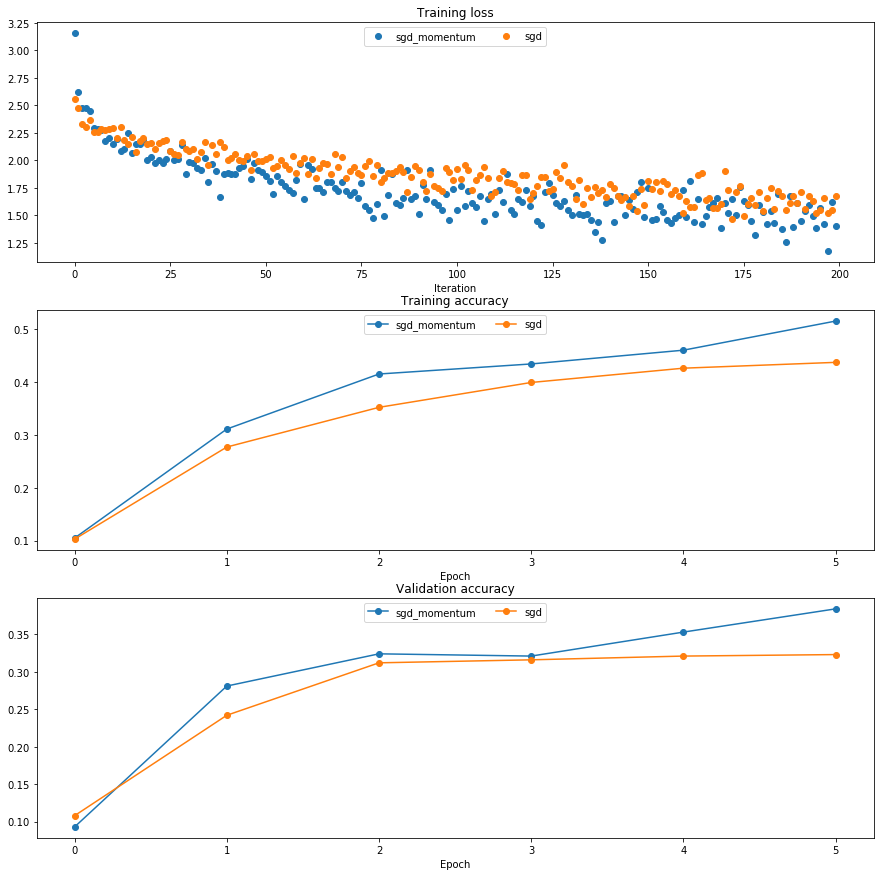

In [14]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

### 更新规则2+3： RMSProp and Adam
    学习速率的更新策略
RMSProp and Adam are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

- `optim.py` ---> `rmsprop`  + `adam` 

#### 检查 RMSProp 更新规则是否正确

In [15]:
# Test RMSProp implementation; you should see errors less than 1e-7
from optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])


# errors less than 1e-7
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.52468751104e-08
cache error:  2.64779558072e-09


#### 检查 Adam 更新规则是否正确

In [19]:
from optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
    [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
    [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
    [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
    [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
    [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
    [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
    [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
    [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
    [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
    [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
    [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
    [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])


# errors around 1e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


#### 训练：三种更新规则对比：deep networks + update rules:

running with  adam
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.143000; val_acc: 0.114000
(Iteration 11 / 200) loss: 2.089203
(Iteration 21 / 200) loss: 2.211850
(Iteration 31 / 200) loss: 1.786014
(Epoch 1 / 5) train acc: 0.393000; val_acc: 0.340000
(Iteration 41 / 200) loss: 1.743813
(Iteration 51 / 200) loss: 1.752165
(Iteration 61 / 200) loss: 2.095686
(Iteration 71 / 200) loss: 1.489003
(Epoch 2 / 5) train acc: 0.411000; val_acc: 0.357000
(Iteration 81 / 200) loss: 1.546641
(Iteration 91 / 200) loss: 1.412223
(Iteration 101 / 200) loss: 1.401821
(Iteration 111 / 200) loss: 1.518780
(Epoch 3 / 5) train acc: 0.483000; val_acc: 0.381000
(Iteration 121 / 200) loss: 1.234374
(Iteration 131 / 200) loss: 1.452269
(Iteration 141 / 200) loss: 1.366984
(Iteration 151 / 200) loss: 1.500379
(Epoch 4 / 5) train acc: 0.542000; val_acc: 0.395000
(Iteration 161 / 200) loss: 1.335077
(Iteration 171 / 200) loss: 1.278162
(Iteration 181 / 200) loss: 1.271657
(Iteration 191 / 200) lo

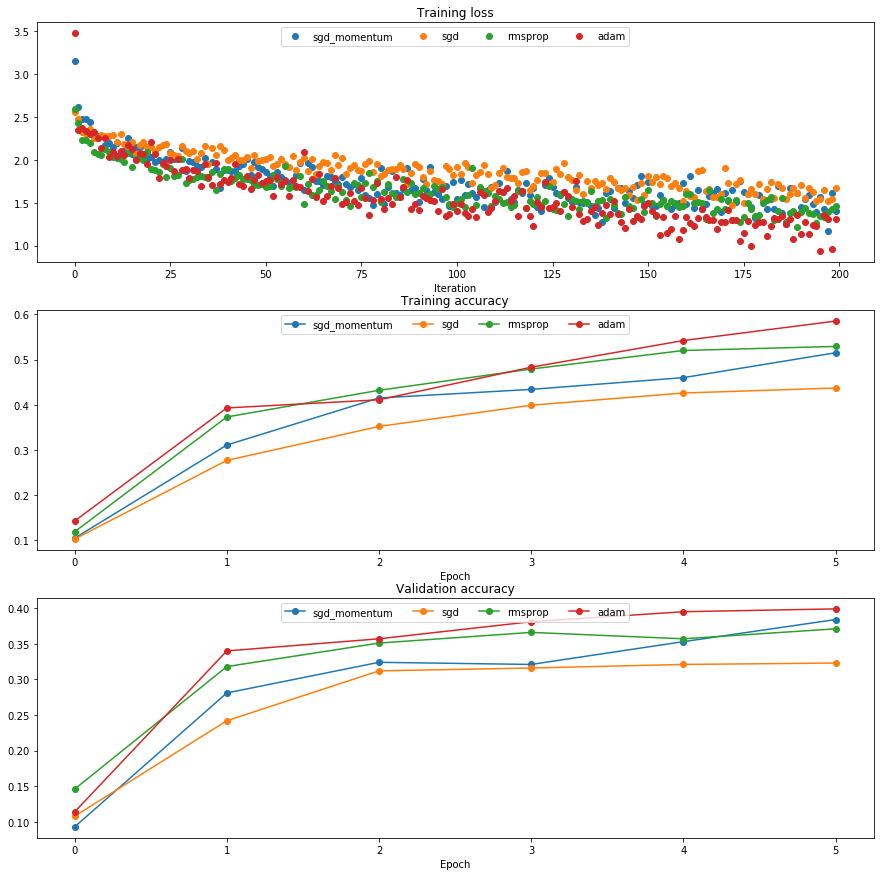

In [20]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()


#### 画图：三种更新规则对比

In [ ]:

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
    
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# 训练模块
- `solver.py` 

用于 training 的模块class，如 训练 `TwoLayerNet`




**passing** the model, dataset, and various optoins (learning rate, batch size, etc) 

**train()**：run the optimization procedure and train the model

**model.params **: contain the parameters that performed best on the validation set over the course of training

**solver.loss_history**: contain a list of all losses encountered during training

**solver.train_acc_history** and **solver.val_acc_history** : lists of the accuracies of the model on the training and validation set at each epoch

```python
data = {
  'X_train': # training data
  'y_train': # training labels
  'X_val': # validation data
  'y_val': # validation labels
}
model = MyAwesomeModel(hidden_size=100, reg=10)
model.params = {.....}
model.loss(X, y)  
model.reg = reg
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=100,
                print_every=100)
solver.train()
```

####  训练

In [13]:
model = TwoLayerNet()
solver = None

model.reg = 0.0
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=100,
                print_every=100)
solver.train()

(Iteration 1 / 4900) loss: 2.302852
(Epoch 0 / 10) train acc: 0.073000; val_acc: 0.081000
(Iteration 101 / 4900) loss: 2.302616
(Iteration 201 / 4900) loss: 2.291944
(Iteration 301 / 4900) loss: 2.287446
(Iteration 401 / 4900) loss: 2.281417
(Epoch 1 / 10) train acc: 0.190000; val_acc: 0.215000
(Iteration 501 / 4900) loss: 2.272922
(Iteration 601 / 4900) loss: 2.270084
(Iteration 701 / 4900) loss: 2.258550
(Iteration 801 / 4900) loss: 2.259695
(Iteration 901 / 4900) loss: 2.226863
(Epoch 2 / 10) train acc: 0.228000; val_acc: 0.244000
(Iteration 1001 / 4900) loss: 2.246841
(Iteration 1101 / 4900) loss: 2.228799
(Iteration 1201 / 4900) loss: 2.213610
(Iteration 1301 / 4900) loss: 2.204449
(Iteration 1401 / 4900) loss: 2.211302
(Epoch 3 / 10) train acc: 0.209000; val_acc: 0.246000
(Iteration 1501 / 4900) loss: 2.155930
(Iteration 1601 / 4900) loss: 2.172385
(Iteration 1701 / 4900) loss: 2.234109
(Iteration 1801 / 4900) loss: 2.170889
(Iteration 1901 / 4900) loss: 2.149309
(Epoch 4 / 10) t

#### 画图

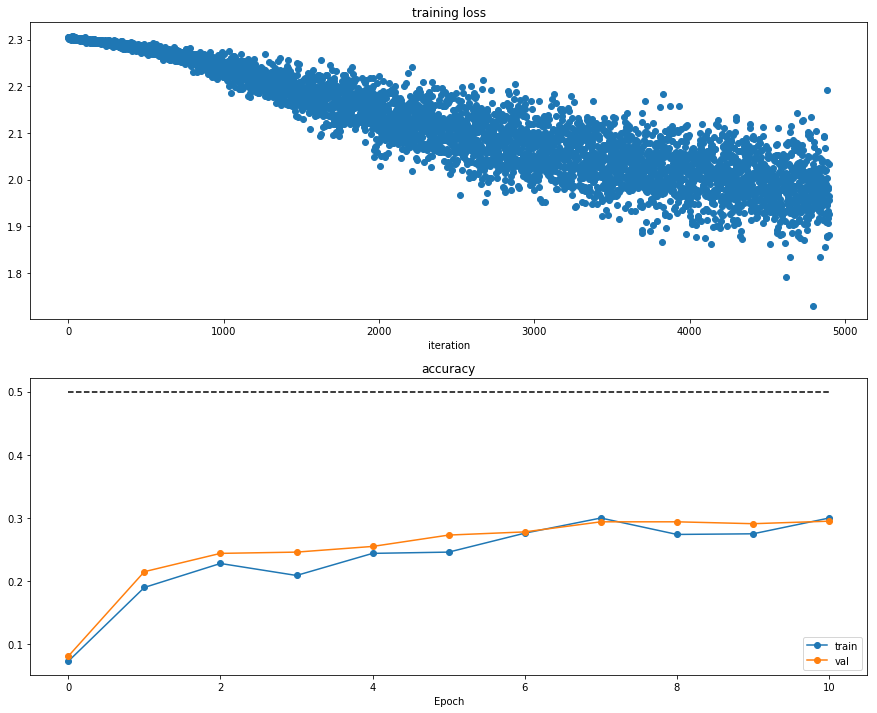

In [14]:
############### visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')

plt.subplot(2, 1, 2)
plt.title('accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()


# 训练：Deep networks(6)+ Batchnorm
    训练6层net 
    on 1000 training examples 
    both with and without batch normalization.

#### 训练：deep net(6)  +  (with 和 without BN)

In [12]:
############## 初始化 deep net
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2

######### 训练 有 BN 的 model
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

######### 训练 木有 BN 的 model
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.304758
(Epoch 0 / 10) train acc: 0.102000; val_acc: 0.101000
(Epoch 1 / 10) train acc: 0.326000; val_acc: 0.287000
(Epoch 2 / 10) train acc: 0.406000; val_acc: 0.311000
(Epoch 3 / 10) train acc: 0.502000; val_acc: 0.330000
(Epoch 4 / 10) train acc: 0.533000; val_acc: 0.302000
(Epoch 5 / 10) train acc: 0.602000; val_acc: 0.346000
(Epoch 6 / 10) train acc: 0.676000; val_acc: 0.327000
(Epoch 7 / 10) train acc: 0.715000; val_acc: 0.331000
(Epoch 8 / 10) train acc: 0.745000; val_acc: 0.312000
(Epoch 9 / 10) train acc: 0.802000; val_acc: 0.331000
(Epoch 10 / 10) train acc: 0.829000; val_acc: 0.313000
(Iteration 1 / 200) loss: 2.302881
(Epoch 0 / 10) train acc: 0.145000; val_acc: 0.140000
(Epoch 1 / 10) train acc: 0.223000; val_acc: 0.177000
(Epoch 2 / 10) train acc: 0.299000; val_acc: 0.298000
(Epoch 3 / 10) train acc: 0.362000; val_acc: 0.313000
(Epoch 4 / 10) train acc: 0.404000; val_acc: 0.310000
(Epoch 5 / 10) train acc: 0.462000; val_acc: 0.324000
(Epoch 6 / 

#### 画图：deep net(6)  +  (with 和 without BN)

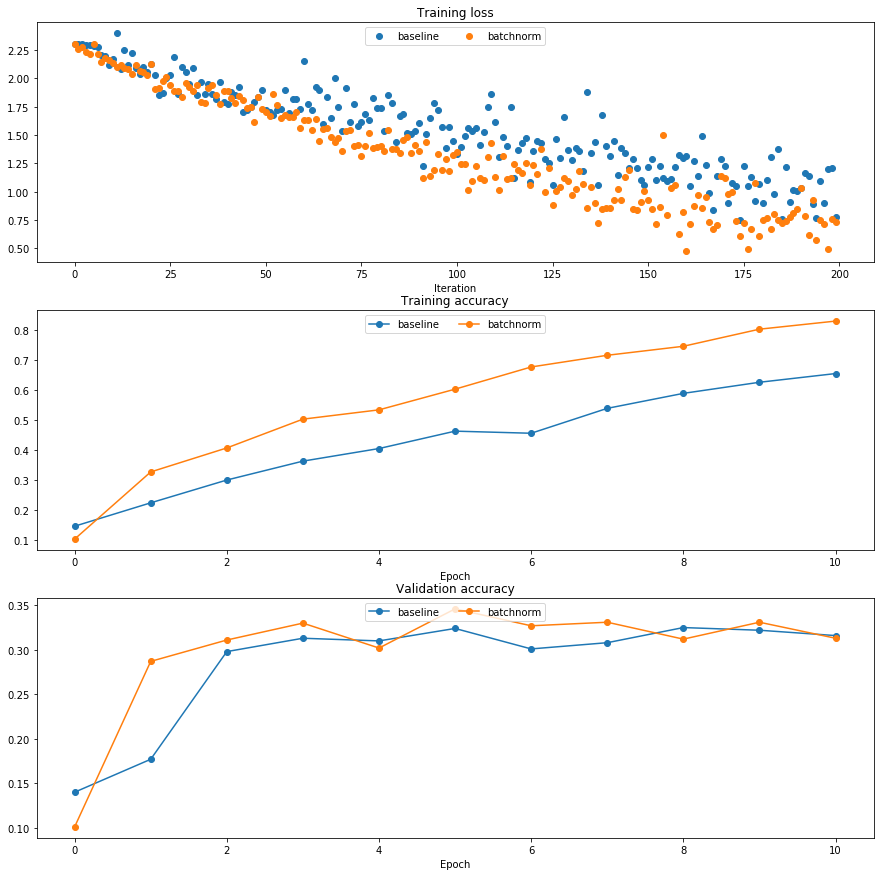

In [13]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

###### 比较 loss
plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

###### 比较 train acc
plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

###### 比较 val acc
plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
    
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# 训练：Deep networks(8) + Batchnorm + weight initialization
    训练8层net 
    on 1000 training examples 
    both with and without batch normalization.
    with 不同scales的权重初始化

#### 训练：deep net(8) +不同scales的权重初始化 + batch normalization ( with and without)

In [15]:
############## 初始化 deep net
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


#### 画图：deep net(8) + training accuracy, validation set accuracy, and training loss

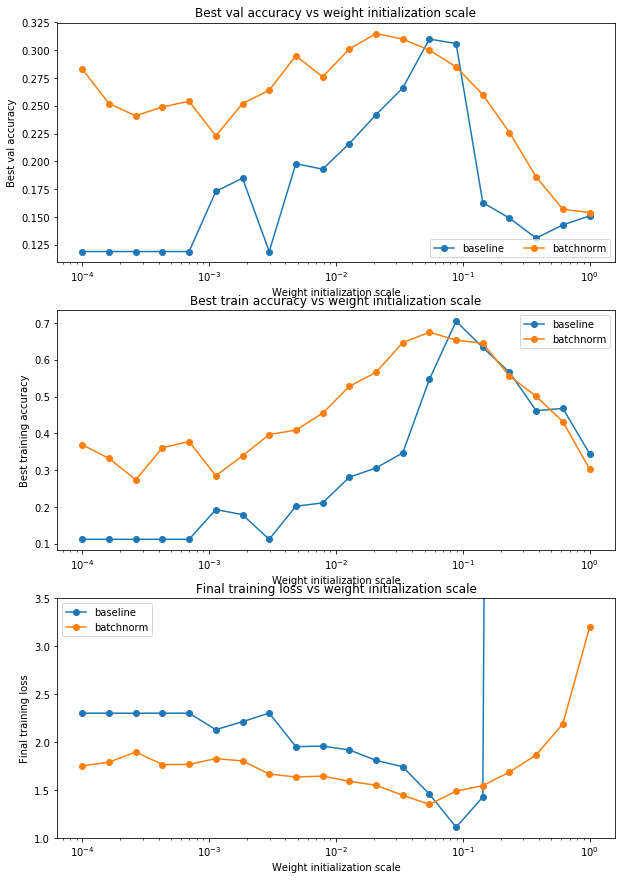

In [16]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))

    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
    
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(10, 15)
plt.show()

# 训练：a good  model!

 at least 50% accuracy on the validation set using a fully-connected net.

In [24]:
data = get_CIFAR10_data()
model = TwoLayerNet(reg=0.9)
solver = Solver(model, data,                
                lr_decay=0.95,                
                print_every=100, num_epochs=40, batch_size=400, 
                update_rule='sgd_momentum',                
                optim_config={'learning_rate': 5e-4, 'momentum': 0.5})

solver.train()                 

(Iteration 1 / 4880) loss: 2.443330
(Epoch 0 / 40) train acc: 0.105000; val_acc: 0.110000
(Iteration 101 / 4880) loss: 2.416863
(Epoch 1 / 40) train acc: 0.106000; val_acc: 0.115000
(Iteration 201 / 4880) loss: 2.397662
(Epoch 2 / 40) train acc: 0.116000; val_acc: 0.126000
(Iteration 301 / 4880) loss: 2.383530
(Epoch 3 / 40) train acc: 0.126000; val_acc: 0.137000
(Iteration 401 / 4880) loss: 2.371200
(Epoch 4 / 40) train acc: 0.142000; val_acc: 0.145000
(Iteration 501 / 4880) loss: 2.359899
(Iteration 601 / 4880) loss: 2.352853
(Epoch 5 / 40) train acc: 0.130000; val_acc: 0.155000
(Iteration 701 / 4880) loss: 2.345598
(Epoch 6 / 40) train acc: 0.150000; val_acc: 0.158000
(Iteration 801 / 4880) loss: 2.339383
(Epoch 7 / 40) train acc: 0.170000; val_acc: 0.170000
(Iteration 901 / 4880) loss: 2.334647
(Epoch 8 / 40) train acc: 0.176000; val_acc: 0.178000
(Iteration 1001 / 4880) loss: 2.330837
(Epoch 9 / 40) train acc: 0.174000; val_acc: 0.180000
(Iteration 1101 / 4880) loss: 2.327520
(Ite

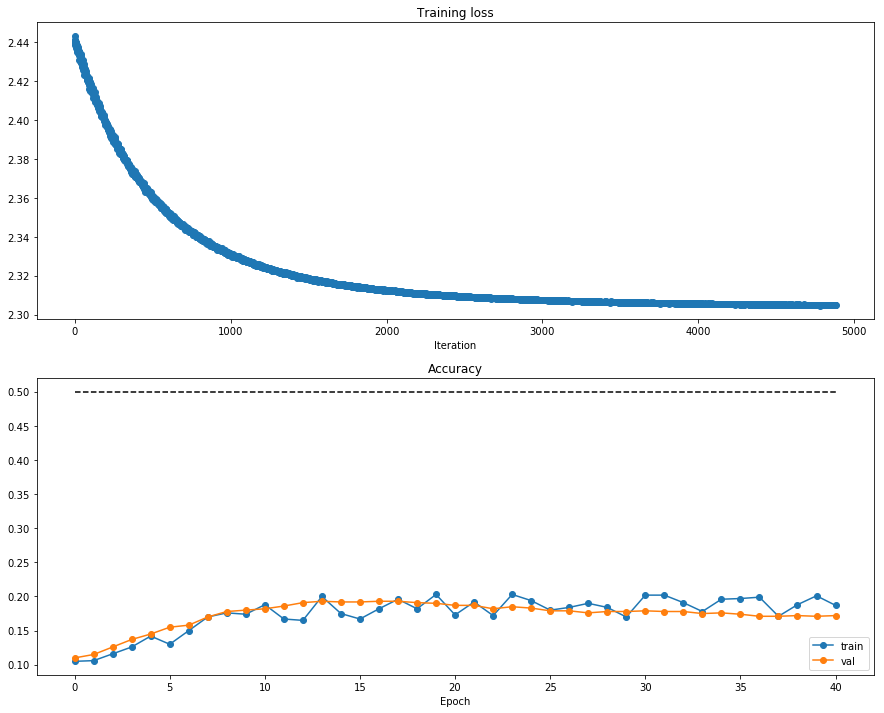

Validation set accuracy:  0.193
Test set accuracy:  0.186


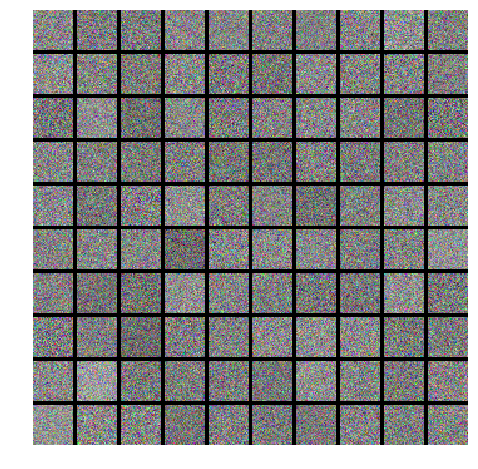

In [26]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()


best_model = model
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print( 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print ('Test set accuracy: ', (y_test_pred == data['y_test']).mean())
# Validation set accuracy:  about 52.9%
# Test set accuracy:  about 54.7%


# Visualize the weights of the best network
from vis_utils import visualize_grid

def show_net_weights(net):    
    W1 = net.params['W1']    
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)    
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))   
    plt.gca().axis('off')    

plt.show()
show_net_weights(best_model)

# Test best model
Run your best model on the validation and test sets.

In [27]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.193
Test set accuracy:  0.186


# ————————————————————

# ————————————————————

# 卷积神经网络：Convolutional Networks

# 普通层模块：Convolution: Naive forward pass
CNN的核心是：卷积操作
- `layers.py`  --> `conv_forward_naive`. 

- 检查 计算的结果 与预期结果 是否一致

In [17]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)

correct_out = np.array([[[[-0.08759809, -0.10987781],
                [-0.18387192, -0.2109216 ]],
                [[ 0.21027089,  0.21661097],
                [ 0.22847626,  0.23004637]],
                [[ 0.50813986,  0.54309974],
                [ 0.64082444,  0.67101435]]],
                [[[-0.98053589, -1.03143541],
                [-1.19128892, -1.24695841]],
                [[ 0.69108355,  0.66880383],
                [ 0.59480972,  0.56776003]],
                [[ 2.36270298,  2.36904306],
                [ 2.38090835,  2.38247847]]]])

# error around 2e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.21214764175e-08


# 通过卷积进行图像处理: Image processing via convolutions

检查实现并获得更好地理解卷积层可以执行的操作类型：

设置一个包含两个图像的输入，手动设置filters，来执行常见图像处理操作（灰度转换和边缘检测）

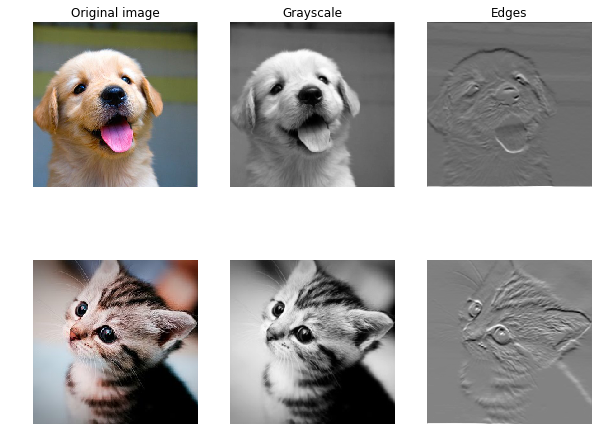

In [30]:
from scipy.misc import imread, imresize

########## 读取 图片
kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
#print (kitten.shape) #(266, 400, 3)  # kitten 是长方形
#print (puppy.shape) #(517, 517, 3)  # puppy 是正方形

########## 将 kitten 转为 正方形
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]
#print (puppy.shape) # (517, 517, 3)

########## 调整 图片尺寸
img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1)) # 先调整尺寸，再调整位置
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))
# print (x[0, :, :, :].shape)  # (3, 200, 200)
# print (x[1, :, :, :].shape)  # (3, 200, 200)

################# 设置一个卷积权重，  holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))  # 2个 fileter，3个渠道，3x3的尺寸

#### 第1个 filter:灰度转换  ---> 将图片的 红绿蓝渠道 转为 灰度grayscale
# w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
# w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
# w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]
w[0, 0, :, :] = [[0, 0, 0], [0, 30, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 60, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 10, 0], [0, 0, 0]]

### 第2个 filter:边缘检测  ---> 检测 蓝色通道中的 水平边缘horizontal edges
# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]


#################设置 Vector of biases 
#不需要灰度filter的任何偏差，但是对于边缘检测filter，要为每个输出添加128，所以没有什么是负数。
b = np.array([0, 128])


################# 计算卷积结果：输入x，滤波器w，用b抵消/offsetting by b
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

    
#################画图
# puppy
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)

# kitten
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])

plt.show()

# 普通层模块：Convolution: Naive backward pass
- `layers.py` --> `conv_backward_naive` 

- 检查 梯度

In [32]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-8'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.15980316116e-08
dw error:  2.24712647485e-10
db error:  3.3726400665e-11


# 普通层模块：Max pooling: Naive forward
- `layers.py` --> `max_pool_forward_naive`

- 检查 计算结果 与 预期结果 是否一致

In [34]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                [-0.20421053, -0.18947368]],
                [[-0.14526316, -0.13052632],
                [-0.08631579, -0.07157895]],
                [[-0.02736842, -0.01263158],
                [ 0.03157895,  0.04631579]]],
                [[[ 0.09052632,  0.10526316],
                [ 0.14947368,  0.16421053]],
                [[ 0.20842105,  0.22315789],
                [ 0.26736842,  0.28210526]],
                [[ 0.32631579,  0.34105263],
                [ 0.38526316,  0.4       ]]]])

# should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


# 普通层模块：Max pooling: Naive backward
- `layers.py` -->  `max_pool_backward_naive` 

- 梯度 检查

In [36]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223e-12


# 快速层模块：Fast layers
-  `cs231n/fast_layers.py`.
 对卷积和拼合层的前向和向后传递的快速实现
 
依赖 Cython extension;需要编译

```bash
python setup.py build_ext --inplace
```


**NOTE:** pooling的快速实现只有在pooling区域不重叠并平铺输入时才能最佳地执行。 如果不满足这些条件，则快速池化实现将不会比初始实现快得多。


In [2]:
!python setup.py build_ext --inplace   

running build_ext
building 'im2col_cython' extension


error: Unable to find vcvarsall.bat


- 比较conv_forward 和 conv_backward 的naive与fast模块 的速度和结果

In [ ]:
# 因环境问题，无法编译成功，反向传播的速度比较 ----》 待续

In [7]:
from fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}


################################## Testing conv_forward
t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))


################################## Testing conv_backward
t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 4.256431s
Fast: 0.032085s
Speedup: 132.660353x
Difference:  4.92640785149e-11


NameError: name 'col2im_6d_cython' is not defined

- 比较max_pool_forward 和 max_pool_backward_backward 的naive与fast模块 速度和结果

In [6]:
from fast_layers import max_pool_forward_fast, max_pool_backward_fast
from time import time

np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}


################################## Testing pool_backward
t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
#print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))


################################## Testing pool_backward
t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.315056s
fast: 0.000000s
difference:  0.0

Testing pool_backward_fast:
Naive: 0.728321s
speedup: 12.328131x
dx difference:  0.0


# 层模式模块：Convolutional "sandwich" layers
- `layer_utils.py` 

    --> conv_relu_pool_forward, conv_relu_pool_backward
    
    --> conv_relu_forward, conv_relu_backward

- 检查 conv_relu_pool_forward, conv_relu_pool_backward

In [9]:
from layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

NameError: name 'col2im_6d_cython' is not defined

- 检查 conv_relu_forward, conv_relu_backward

In [10]:
from layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

NameError: name 'col2im_6d_cython' is not defined

# 分类器模块： Three-layer ConvNet
- `classifiers/cnn.py` --> `ThreeLayerConvNet` class

## 检查损失：Sanity check loss
一旦创建新net，首先 检查损失！！ 

When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. 

In [17]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

NameError: name 'col2im_6d_cython' is not defined

## 检查梯度：Gradient check
损失看起来合理后，使用 数值梯度检查，确保 backward pass是正确. 

方法： use a small amount of artifical data and a small number of neurons at each layer.


In [18]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

NameError: name 'col2im_6d_cython' is not defined

## 拟合小数据：Overfit small data
A nice trick is to train your model with just a few training samples. 

使用一些训练样本 训练模型，使其出现过拟合，即出现 非常高的train准确度以及相对较低的val准确度

In [21]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

NameError: name 'col2im_6d_cython' is not defined

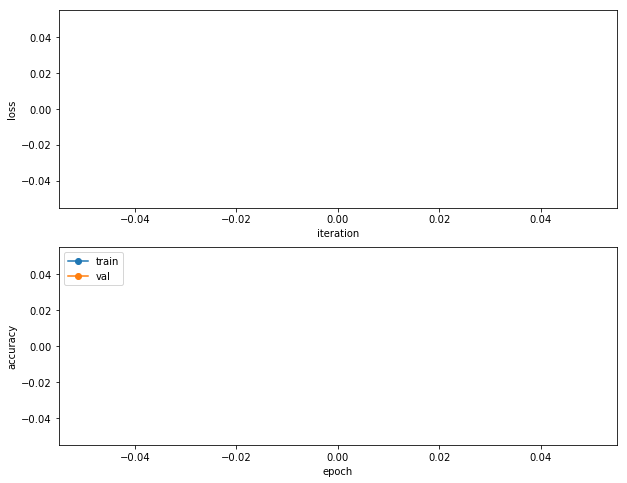

In [22]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
训练3层conv net

In [23]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

NameError: name 'col2im_6d_cython' is not defined

## Visualize Filters
可视化 first-layer convolutional filters

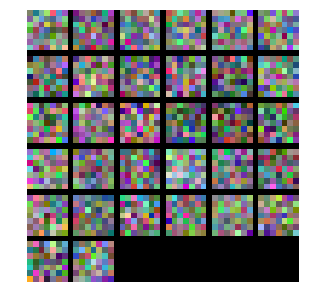

In [25]:
from vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# 空间批量归一化？：Spatial Batch Normalization
批量标准化也可以用于卷积网络，被称为“空间批量标准化”(spatial batch normalization)


Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

## 普通层模块：Spatial batch normalization: forward
- `layers.py`--> `spatial_batchnorm_forward`

In [29]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 9.33463814  8.90909116  9.11056338]
  Stds:  [ 3.61447857  3.19347686  3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [  6.18949336e-16   5.99520433e-16  -1.22124533e-16]
  Stds:  [ 0.99999962  0.99999951  0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.  7.  8.]
  Stds:  [ 2.99999885  3.99999804  4.99999798]


In [30]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [ 0.96718744  1.0299714   1.02887624  1.00585577]


## 普通层模块：Spatial batch normalization: backward
- `layers.py`--> `spatial_batchnorm_backward`

In [31]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.78664820164e-07
dgamma error:  7.09748171136e-12
dbeta error:  3.27560872528e-12
